Forward Probabilities:
 [[0.25      0.05     ]
 [0.021     0.03     ]
 [0.00456   0.00204  ]
 [0.0008112 0.000264 ]]
Backward Probabilities:
 [[0.003936 0.001824]
 [0.0352   0.0112  ]
 [0.2      0.08    ]
 [1.       1.      ]]
Viterbi Probability: 0.003200000000000001
Viterbi Path (0=Happy, 1=Angry): [0, 0, 0]


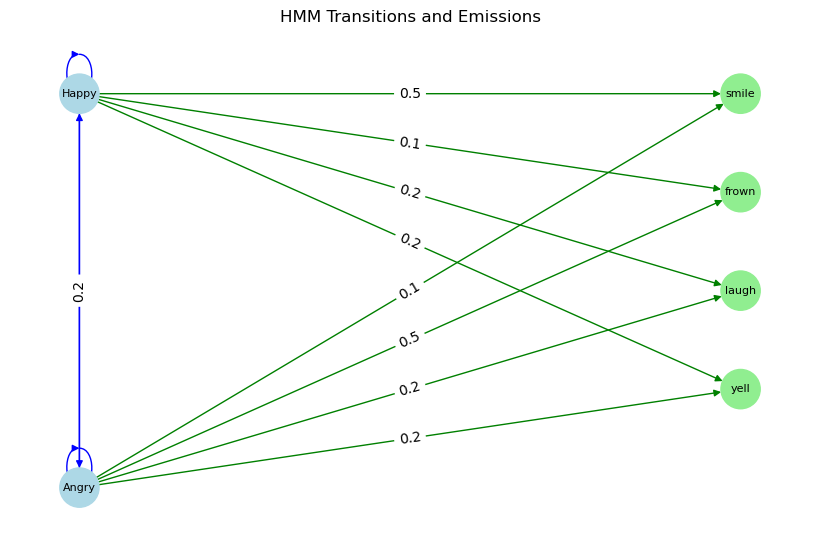

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def forward_backward(obs, states, init_probs, trans_mat, emit_mat):
    T, N = len(obs), len(states)
    alpha = np.zeros((T, N))
    alpha[0] = init_probs * emit_mat[:, obs[0]]
    for t in range(1, T):
        alpha[t] = np.sum(alpha[t-1] * trans_mat, axis=1) * emit_mat[:, obs[t]]
    
    beta = np.zeros((T, N))
    beta[-1] = 1
    for t in range(T-2, -1, -1):
        beta[t] = trans_mat @ (emit_mat[:, obs[t+1]] * beta[t+1])
    
    return alpha, beta

def viterbi(init_probs, trans_mat, emit_mat, obs):
    T, N = len(obs), len(init_probs)
    viterbi = np.zeros((T, N))
    backpointer = np.zeros((T, N), dtype=int)
    viterbi[0] = init_probs * emit_mat[:, obs[0]]
    
    for t in range(1, T):
        probs = viterbi[t-1][:, None] * trans_mat * emit_mat[:, obs[t]]
        viterbi[t] = np.max(probs, axis=0)
        backpointer[t] = np.argmax(probs, axis=0)
    
    path = [np.argmax(viterbi[-1])]
    for t in range(T-1, 0, -1):
        path.append(backpointer[t, path[-1]])
    path.reverse()
    
    return np.max(viterbi[-1]), path

def plot_hmm_combined(states, obs_names, trans_mat, emit_mat):
    G = nx.DiGraph()
    for s in states:
        G.add_node(s, layer=0)
    for o in obs_names:
        G.add_node(o, layer=1)
    
    for i, s1 in enumerate(states):
        for j, s2 in enumerate(states):
            if trans_mat[i, j] > 0:
                G.add_edge(s1, s2, weight=trans_mat[i, j], type='trans')
        for k, o in enumerate(obs_names):
            if emit_mat[i, k] > 0:
                G.add_edge(s1, o, weight=emit_mat[i, k], type='emit')
    
    pos = {s: (0, -i) for i, s in enumerate(states)}
    pos.update({o: (2, -j / len(obs_names)) for j, o in enumerate(obs_names)})
    
    plt.figure(figsize=(8, 5))
    nx.draw(G, pos, nodelist=states+obs_names, node_color=['lightblue']*len(states)+['lightgreen']*len(obs_names), 
            node_size=800, with_labels=True, font_size=8, 
            edge_color=[('b' if d['type'] == 'trans' else 'g') for u, v, d in G.edges(data=True)], 
            edge_cmap=None)
    nx.draw_networkx_edge_labels(G, pos, {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)})
    plt.title("HMM Transitions and Emissions")
    plt.axis('off')
    plt.show()

# Example data
states = ['Happy', 'Angry']
obs_names = ['smile', 'frown', 'laugh', 'yell']
init_probs = np.array([0.5, 0.5])
trans_mat = np.array([[0.8, 0.2], [0.2, 0.2]])
emit_mat = np.array([[0.5, 0.1, 0.2, 0.2], [0.1, 0.5, 0.2, 0.2]])

# Run algorithms
obs = [obs_names.index(o) for o in obs_names]
alpha, beta = forward_backward(obs, states, init_probs, trans_mat, emit_mat)
print("Forward Probabilities:\n", alpha)
print("Backward Probabilities:\n", beta)

viterbi_obs = [obs_names.index(o) for o in ['laugh', 'frown', 'smile']]
prob, path = viterbi(init_probs, trans_mat, emit_mat, viterbi_obs)
print("Viterbi Probability:", prob)
print("Viterbi Path (0=Happy, 1=Angry):", path)

# Plot combined diagram
plot_hmm_combined(states, obs_names, trans_mat, emit_mat)

Forward:
 [[0.25      0.05     ]
 [0.021     0.03     ]
 [0.00456   0.00204  ]
 [0.0008112 0.000264 ]]
Backward:
 [[0.003936 0.001824]
 [0.0352   0.0112  ]
 [0.2      0.08    ]
 [1.       1.      ]]
Viterbi Prob: 0.003200000000000001
Viterbi Path: [0, 0, 0]


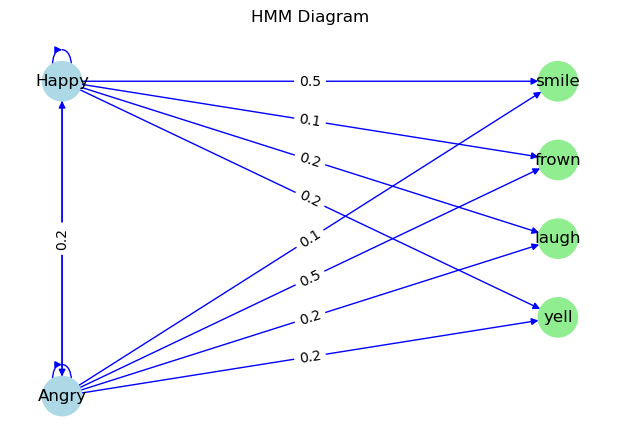

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def forward_backward(obs, s, p, t, e):
    T, N = len(obs), len(s)
    a = np.zeros((T, N))
    a[0] = p * e[:, obs[0]]
    for i in range(1, T):
        a[i] = np.sum(a[i-1] * t, 1) * e[:, obs[i]]
    b = np.zeros((T, N))
    b[-1] = 1
    for i in range(T-2, -1, -1):
        b[i] = t @ (e[:, obs[i+1]] * b[i+1])
    return a, b

def viterbi(p, t, e, obs):
    T, N = len(obs), len(p)
    v = np.zeros((T, N))
    bp = np.zeros((T, N), dtype=int)
    v[0] = p * e[:, obs[0]]
    for i in range(1, T):
        pr = v[i-1][:, None] * t * e[:, obs[i]]
        v[i] = np.max(pr, 0)
        bp[i] = np.argmax(pr, 0)
    path = [np.argmax(v[-1])]
    for i in range(T-1, 0, -1):
        path.append(bp[i, path[-1]])
    return np.max(v[-1]), path[::-1]

def plot_hmm(s, o, t, e):
    G = nx.DiGraph()
    for x in s + o:
        G.add_node(x)
    for i, s1 in enumerate(s):
        for j, s2 in enumerate(s):
            if t[i, j] > 0:
                G.add_edge(s1, s2, w=t[i, j])
        for k, x in enumerate(o):
            if e[i, k] > 0:
                G.add_edge(s1, x, w=e[i, k])
    pos = {x: (0, -i) for i, x in enumerate(s)}
    pos.update({x: (2, -j/len(o)) for j, x in enumerate(o)})
    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, with_labels=True, node_color=['lightblue']*len(s)+['lightgreen']*len(o), 
            node_size=800, edge_color=[('b' if u in s else 'g') for u, v in G.edges()])
    nx.draw_networkx_edge_labels(G, pos, {(u, v): f'{d["w"]:.1f}' for u, v, d in G.edges(data=True)})
    plt.title("HMM Diagram")
    plt.axis('off')
    plt.show()

# Data
s = ['Happy', 'Angry']
o = ['smile', 'frown', 'laugh', 'yell']
p = np.array([0.5, 0.5])
t = np.array([[0.8, 0.2], [0.2, 0.2]])
e = np.array([[0.5, 0.1, 0.2, 0.2], [0.1, 0.5, 0.2, 0.2]])

# Run
obs = [o.index(x) for x in o]
a, b = forward_backward(obs, s, p, t, e)
print("Forward:\n", a)
print("Backward:\n", b)

v_obs = [o.index(x) for x in ['laugh', 'frown', 'smile']]
prob, path = viterbi(p, t, e, v_obs)
print("Viterbi Prob:", prob)
print("Viterbi Path:", path)

plot_hmm(s, o, t, e)